In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
from src.models.vae.vae import VAE
from src.scripts.etl_process.ETLProcessor import ETLProcessor
from matplotlib import pyplot as plt

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim: int = 3):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_dim, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),

            nn.Conv2d(32, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 2 * 2, 512),  
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        out = self.fc_layers(x)
        return out


class VAEGAN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        residual_hiddens: int,
        num_residual_layers: int,
        latent_dim: int,
        device: str
    ):
        super(VAEGAN, self).__init__()        
        self.device = device
        self.vae = VAE(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            residual_hiddens=residual_hiddens,
            num_residual_layers=num_residual_layers,
            latent_dim=latent_dim,
            device=device,
        )
        
        self.discriminator = Discriminator(
            input_dim=input_dim
        )
    def forward(self, x: torch.Tensor) -> dict:
        x_recon = self.vae(x)
        
        d_real = self.discriminator(x)
        d_fake = self.discriminator(x_recon)

        return {
            "recon": x_recon,
            "mu": mu,
            "logvar": logvar,
            "d_real": d_real,
            "d_fake": d_fake,
        }

    def loss_function(self, x: torch.Tensor, recon: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss

In [ ]:

torch.save(VAE)

In [3]:
vae = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=2,
    latent_dim=256,
    device='cpu',
)

In [4]:
etl = ETLProcessor(
    kaggle_dataset="mahmudulhaqueshawon/cat-image",
    raw_dir="../data/raw_data",
    split_dir="../data/data_splits",
)
train_loader, val_loader, test_loader = etl.process()

[INFO] Dataset 'mahmudulhaqueshawon/cat-image' already exists at ../data/raw_data, skipping copy.


In [5]:
vae = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=2,
    latent_dim=256,
    device='cpu',
)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(params=vae.parameters())

for i in range(10):
    imgs = next(iter(train_loader))[0]
    recons = vae(imgs)['recon']
    optimizer.zero_grad()
    loss = loss_fn(imgs, recons)
    print(loss)
    optimizer.step()
    

tensor(0.3038, grad_fn=<MseLossBackward0>)
tensor(0.3025, grad_fn=<MseLossBackward0>)
tensor(0.3025, grad_fn=<MseLossBackward0>)
tensor(0.3147, grad_fn=<MseLossBackward0>)
tensor(0.3021, grad_fn=<MseLossBackward0>)
tensor(0.2844, grad_fn=<MseLossBackward0>)
tensor(0.2906, grad_fn=<MseLossBackward0>)
tensor(0.2855, grad_fn=<MseLossBackward0>)
tensor(0.2936, grad_fn=<MseLossBackward0>)
tensor(0.2955, grad_fn=<MseLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


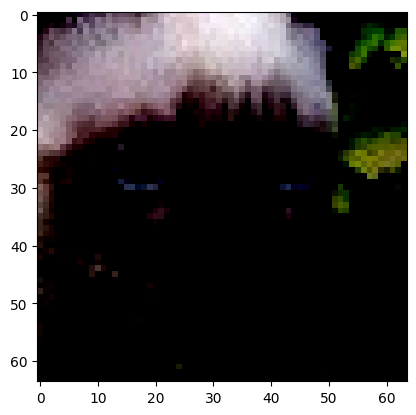

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40730888..0.3705617].


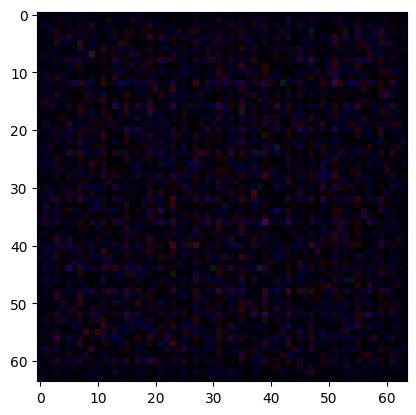

In [6]:
img = next(iter(train_loader))[0][0]
plt.imshow(img.permute(1,2,0))
plt.show()
recon = vae(img.unsqueeze(0))
plt.imshow(recon['recon'].detach().squeeze(0).permute(1,2,0))
plt.show()